In [1]:
import pickle
import time
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from statistics import median

from envs import TradingEnv
from agent import DQNAgent
from utils import get_data, get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
data = np.around(get_data())
train_data = data[:, :3526]
test_data = data[:, 3526:]

In [3]:
episode=2000
batch_size=32
initial_invest=20000

In [4]:
env = TradingEnv(train_data, initial_invest)
state_size = env.observation_space.shape
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 27)                891       
Total params: 2,203
Trainable params: 2,203
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [5]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {}/{}, median profit so far: {}".format(
                    e + 1, episode, median(train_results['value'].tolist())))
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if (e + 1) % 10 == 0:
        agent.save('weights/{}-dqn.h5'.format(time.strftime('%Y%m%d%H%M')))



....................
episode: 20/2000, median profit so far: 20301.0
....................
episode: 40/2000, median profit so far: 26456.0
....................
episode: 60/2000, median profit so far: 27492.0
....................
episode: 80/2000, median profit so far: 25428.0
....................
episode: 100/2000, median profit so far: 25831.0
....................
episode: 120/2000, median profit so far: 26511.0
....................
episode: 140/2000, median profit so far: 27492.0
....................
episode: 160/2000, median profit so far: 26511.0
....................
episode: 180/2000, median profit so far: 25290.0
....................
episode: 200/2000, median profit so far: 25290.0
....................
episode: 220/2000, median profit so far: 25223.0
....................
episode: 240/2000, median profit so far: 25460.0
....................
episode: 260/2000, median profit so far: 26456.0
....................
episode: 280/2000, median profit so far: 27878.0
....................
e

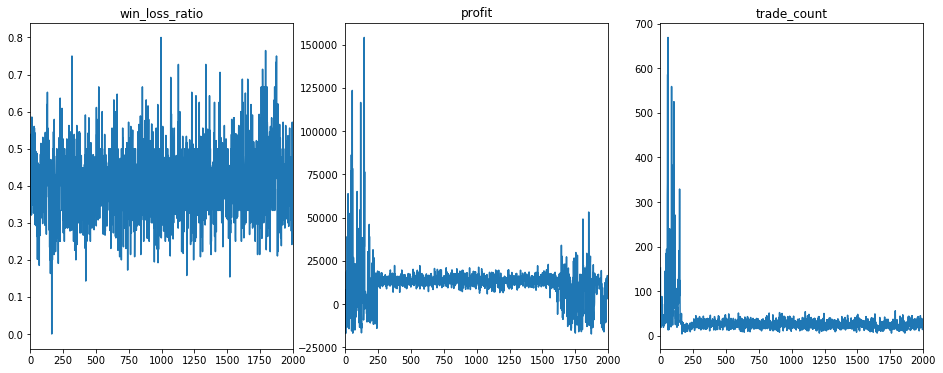

In [6]:
train_results['profit'] = train_results['value'] - initial_invest
columns_to_plot = ['win_loss_ratio', 'profit', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

## Test

In [7]:
state_size = env.observation_space.shape
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)
test_portfolio_value = []

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 27)                891       
Total params: 2,203
Trainable params: 2,203
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# remake the env with test data
env = TradingEnv(test_data, initial_invest)
# load trained weights from latest saved
latest_weights_file = max(glob.glob('weights/*.h5'), key=os.path.getctime)
print('loading weights file: {0}'.format(latest_weights_file))
agent.load(latest_weights_file)
test_results = pd.DataFrame()

loading weights file: weights/201912040226-dqn.h5


In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [10]:
test_results['profit'] = test_results['value'] - initial_invest

In [11]:
print('Median profit: {0} ({1}%)'.format(
    test_results['profit'].median(),
    test_results['profit'].median() / initial_invest * 100
))

Median profit: 2699.5 (13.4975%)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dfb1310>]],
      dtype=object)

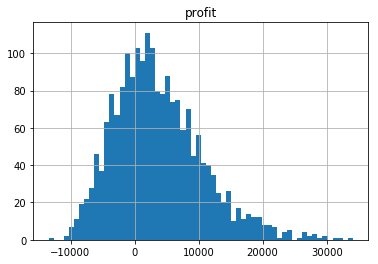

In [12]:
test_results.hist(column='profit', bins=60)